In [156]:
import pandas as pd
import seaborn as sns

In [5]:
# downloaded Google Sheet provided by SC and saved locally
path = '../data/Thank You Call Data - Sheet1.tsv'
raw_data = pd.read_csv(path, sep = '\t')

# Validation

Do some sanity checks to confirm:
    
- Data Types & Nulls
   
- Header & trailers make sense
   
- No dupes of customer IDs

- Understand GMV & LTR

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23759 entries, 0 to 23758
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   USER_ID           23759 non-null  int64  
 1   CHECK_OUT_MONTH   23759 non-null  object 
 2   THANK_YOU_STATUS  23759 non-null  object 
 3   LTR               23202 non-null  float64
 4   BOOKINGS          23202 non-null  float64
 5   GMV               23202 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.1+ MB


In [58]:
raw_data.describe()

,USER_ID,LTR,BOOKINGS,GMV
count,2.375900e+04,23202.000000,23202.000000,23202.000000
mean,1.628785e+06,73.784503,1.920869,1120.685785
std,6.329651e+05,106.030714,15.036952,1831.220249
min,1.015700e+04,0.006633,1.000000,502.554000
25%,1.188946e+06,42.504000,1.000000,592.224750
50%,1.637085e+06,53.322500,1.000000,700.493500
75%,2.131534e+06,70.994000,2.000000,871.887500
max,2.839099e+06,5122.086550,2012.000000,73247.220000


# Outliers
- as usual, a tremendous amount of outliers are present in the data.
- we will have to truncate these outliers for our exploratory analysis. Let's assume the top 1% of customers to have a better view to the visualizations and metrics.

In [11]:
raw_data.head(20)

,USER_ID,CHECK_OUT_MONTH,THANK_YOU_STATUS,LTR,BOOKINGS,GMV
0,10157,2018-09-01,thank_you_call,106.640369,6.0,4926.957
1,10263,2018-03-01,thank_you_call,388.322847,25.0,18481.635
2,10362,2018-01-01,thank_you_call,588.327102,15.0,7010.647
3,10382,2018-11-01,thank_you_call,6.402000,2.0,1144.032
4,10463,2019-01-01,no_call,51.815610,3.0,1271.090
5,10664,2018-11-01,no_call,270.969193,6.0,4405.125
6,10683,2018-10-01,thank_you_call,104.709000,6.0,1568.437
7,10685,2018-09-01,thank_you_call,81.052356,2.0,1633.207
8,10705,2018-07-01,thank_you_call,354.495482,8.0,5004.103
9,10954,2018-07-01,thank_you_call,131.854195,7.0,2465.017


In [12]:
raw_data.tail(5)

,USER_ID,CHECK_OUT_MONTH,THANK_YOU_STATUS,LTR,BOOKINGS,GMV
23754,2836711,2019-06-01,no_call,124.267,1.0,639.098
23755,2837210,2019-06-01,no_call,67.848,1.0,560.235
23756,2837700,2019-06-01,no_call,42.812,1.0,510.714
23757,2837802,2019-06-01,no_call,48.521,1.0,573.206
23758,2839099,2019-06-01,no_call,60.214,1.0,695.759


In [14]:
raw_data.USER_ID.count() == raw_data.USER_ID.nunique()

True

In [25]:
(raw_data.LTR / raw_data.GMV).max()

0.4371279539516183

In [75]:
(raw_data.LTR < raw_data.GMV).max()

True

### Data Types
- months are interepreted as string .Thats probably fine for now

### Dupes
- not an issue.

### GMV & LTR
- Sanity check that LTR is greater than GMV for no one. 43% max lifetime margin. Assume this is gross margin for any other calculations in the doc. 

# Nulls
- Data dictionary for BOOKINGS

```BOOKINGS
int
The total number of distinct bookings that the user has made using Snaptravel.```

- Suggests that maybe these customers cancelled their bookings after creating an account. Let's confirm none got the email.

In [91]:
raw_data[raw_data.BOOKINGS.isnull()].groupby('THANK_YOU_STATUS').count()

,USER_ID,CHECK_OUT_MONTH,LTR,BOOKINGS,GMV
THANK_YOU_STATUS,,,,,
no_call,293,293,0,0,0
thank_you_call,264,264,0,0,0


# Null Conclusion
- It's strange these customers have no bookings, but received a thank you call. I assumed these customers might have cancelled there reservations. Let's drop these users and assume that might be the root case.

In [79]:
# method chain and test this post EDA
margin_data = raw_data.assign(MARGIN = lambda x: x.LTR / x.GMV)
complete_data = margin_data[margin_data.BOOKINGS.notnull()]
flagged_data = complete_data.assign(CUSTOMER_RETURNED = lambda x: x.BOOKINGS > 1)

In [117]:
flagged_data.head()

,USER_ID,CHECK_OUT_MONTH,THANK_YOU_STATUS,LTR,BOOKINGS,GMV,MARGIN,CUSTOMER_RETURNED
0,10157,2018-09-01,thank_you_call,106.640369,6.0,4926.957,0.021644,True
1,10263,2018-03-01,thank_you_call,388.322847,25.0,18481.635,0.021011,True
2,10362,2018-01-01,thank_you_call,588.327102,15.0,7010.647,0.083919,True
3,10382,2018-11-01,thank_you_call,6.402000,2.0,1144.032,0.005596,True
4,10463,2019-01-01,no_call,51.815610,3.0,1271.090,0.040765,True


In [118]:
flagged_data.describe()

,USER_ID,LTR,BOOKINGS,GMV,MARGIN
count,2.320200e+04,23202.000000,23202.000000,23202.000000,23202.000000
mean,1.645553e+06,73.784503,1.920869,1120.685785,0.072580
std,6.279506e+05,106.030714,15.036952,1831.220249,0.027831
min,1.015700e+04,0.006633,1.000000,502.554000,0.000009
25%,1.238449e+06,42.504000,1.000000,592.224750,0.060977
50%,1.653670e+06,53.322500,1.000000,700.493500,0.076968
75%,2.141938e+06,70.994000,2.000000,871.887500,0.085636
max,2.839099e+06,5122.086550,2012.000000,73247.220000,0.437128


# Data Exploration

#### More rigorous hypothesis testing to come but some high level questions:
    
- How many customers transact more than once? This seems like the most likely behavior you might be trying to stimulate
- What does GMV, LTR, Margin look like at a high level, Bookings; by test
- Does time of year have an impact on return likelihood?
- What does seasonality look like?
- Is there subsets of data that are likely to respond to 

In [116]:
flagged_data.CUSTOMER_RETURNED.agg(['mean','count'])

mean         0.276226
count    23202.000000
Name: CUSTOMER_RETURNED, dtype: float64

In [97]:
flagged_data.groupby('THANK_YOU_STATUS').CUSTOMER_RETURNED.agg(['mean','count'])

,mean,count
THANK_YOU_STATUS,,
no_call,0.270242,15179
thank_you_call,0.287548,8023


- a decent amount of customers transact overall at SC.
- Results suggest that on average, the campaign is reasonably successful at a second booking

## Business Metrics

In [96]:
flagged_data.groupby(['THANK_YOU_STATUS'])[['BOOKINGS','GMV','LTR','MARGIN']].mean()

,BOOKINGS,GMV,LTR,MARGIN
THANK_YOU_STATUS,,,,
no_call,1.957573,1088.997353,72.852304,0.073287
thank_you_call,1.851427,1180.638259,75.548163,0.071243


- Higher bookings for the no_call group likely driven by outliers and the 1000 time visiting customer i saw above. lets trim those now.

# Outlier & Omissions

In [107]:
# Calculate 99% percentile. Will want to omit outliers from further visualization. Use 8000 as cutoff.
flagged_data[['GMV']].quantile(0.99)

GMV    7987.81567
Name: 0.99, dtype: float64

In [108]:
# Calculate 99% percentile. Will want to omit outliers from further visualization. Use 12 as cutoff.
flagged_data[['BOOKINGS']].quantile(0.99)

BOOKINGS    12.0
Name: 0.99, dtype: float64

In [109]:
filtered_data = flagged_data[(flagged_data.BOOKINGS < 12) & (flagged_data.GMV < 8000)]

## Baselining new dataset

In [119]:
filtered_data.describe()

,USER_ID,LTR,BOOKINGS,GMV,MARGIN
count,2.285400e+04,22854.000000,22854.000000,22854.000000,22854.000000
mean,1.655187e+06,65.549123,1.559246,964.582378,0.072810
std,6.229149e+05,53.678673,1.299961,829.723676,0.027835
min,1.015700e+04,0.006633,1.000000,502.554000,0.000009
25%,1.255499e+06,42.295000,1.000000,590.818000,0.061803
50%,1.659737e+06,52.998000,1.000000,696.600500,0.076969
75%,2.149733e+06,69.836250,2.000000,845.966750,0.085695
max,2.839099e+06,751.927000,11.000000,7995.338000,0.437128


In [110]:
filtered_data.groupby('THANK_YOU_STATUS').CUSTOMER_RETURNED.agg(['mean','count'])

,mean,count
THANK_YOU_STATUS,,
no_call,0.259559,14960
thank_you_call,0.275906,7894


- No material change

In [111]:
filtered_data.groupby(['THANK_YOU_STATUS'])[['BOOKINGS','GMV','LTR','MARGIN']].mean()

,BOOKINGS,GMV,LTR,MARGIN
THANK_YOU_STATUS,,,,
no_call,1.533422,944.920356,65.100172,0.073493
thank_you_call,1.608183,1001.844078,66.399934,0.071515


- the omission of outlier users now addresses the abnormality in users. Let's continue to this for further analysis
- thank you call did stimulate positive financials across fewer bookings. Looks like a segment of high value clients could be stimulated by the thank you call. There's an opportuntiy for identification of high value customers here (high end travel, etc)

# Distributions

- let's understand how some of our transactional distributions look

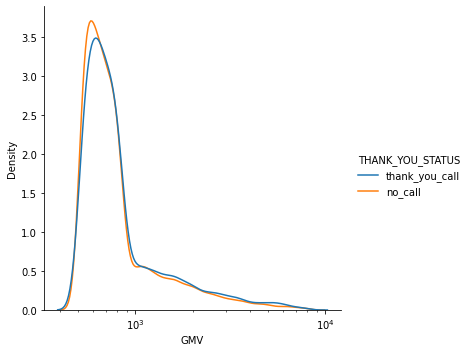

In [127]:
sns.displot(data = filtered_data, 
            x= 'GMV', 
            hue = 'THANK_YOU_STATUS',
            kind="kde",
            common_norm = False,
            log_scale = True)

- Right tail of thank you call suggests that we are successful in shifting GMV for users higher

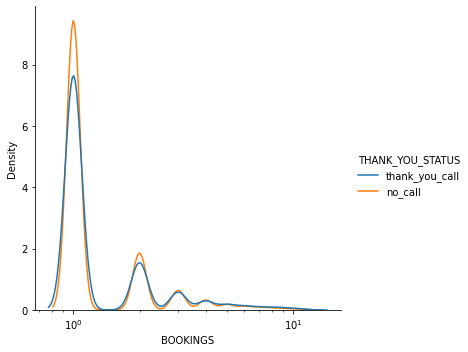

In [155]:
sns.displot(data = filtered_data, 
            x= 'BOOKINGS', 
            hue = 'THANK_YOU_STATUS',
            kind="kde",
            common_norm = False,
            log_scale = True)

- Same situation. Incremental bookings are tremendously more successful. likely comes down to individual economics